<a href="https://colab.research.google.com/github/Bira0/GroupB/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Getting the Data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/customer-segmentation-tutorial-in-python


In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Load the dataset
csv_path = os.path.join(path, "Mall_Customers.csv")
data = pd.read_csv(csv_path)

data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#Exploration

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


See if NULL values exist

In [11]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Gender                  200 non-null    int64
 2   Age                     200 non-null    int64
 3   Annual Income (k$)      200 non-null    int64
 4   Spending Score (1-100)  200 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB


,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [5]:
#data.drop(["CustomerID"], axis=1, inplace=True)

In [29]:
X = data.drop('CustomerID', axis=1)

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Annual Income (k$)'}>],
       [<Axes: title={'center': 'Spending Score (1-100)'}>, <Axes: >]],
      dtype=object)

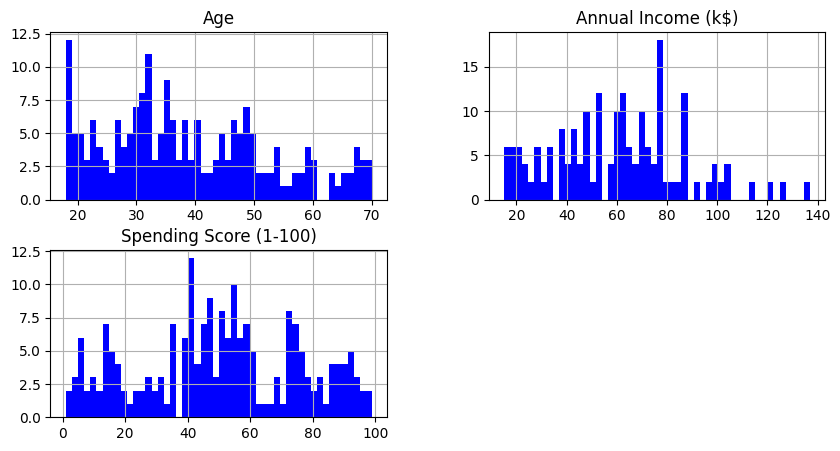

In [31]:
X.hist( color='b', bins=50, figsize=(10,5))

In [32]:
data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})
#data[['Gender']]

In [33]:
#X = data.drop(['Gender'], axis=1)

<Axes: >

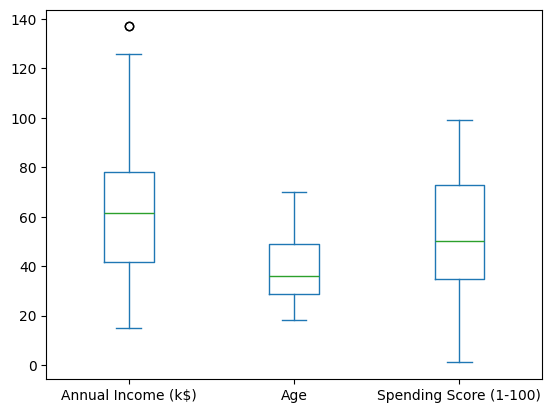

In [34]:
X[['Annual Income (k$)', 'Age' ,'Spending Score (1-100)']].plot(kind='box')

#Preprocessing

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Apply PCA

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

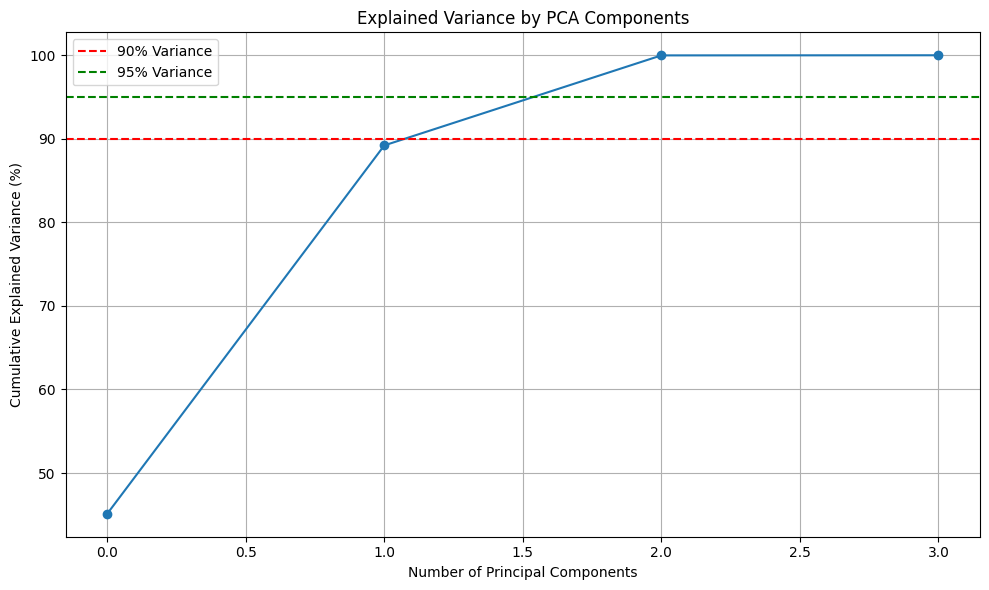

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
pca = PCA().fit(X)
sum_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot((sum_variance)*100, marker='o')
plt.axhline(y=90, color='r', linestyle='--', label='90% Variance')
plt.axhline(y=95, color='g', linestyle='--', label='95% Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


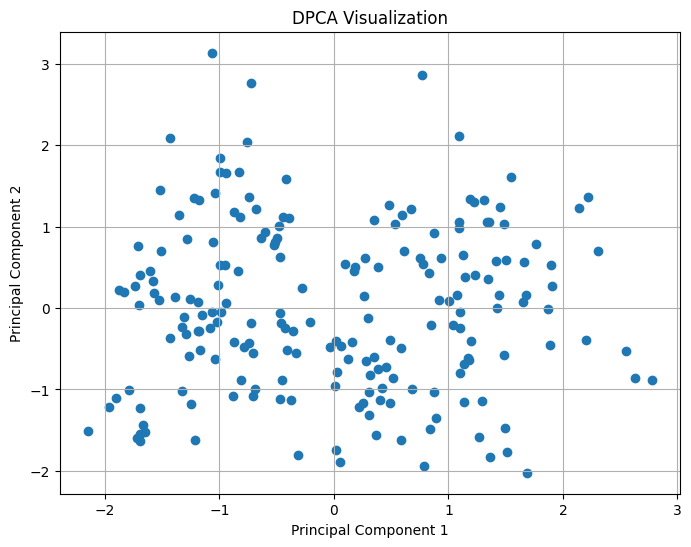

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title("DPCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

#T_SNE

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

Visualize clusters formed after PCA.

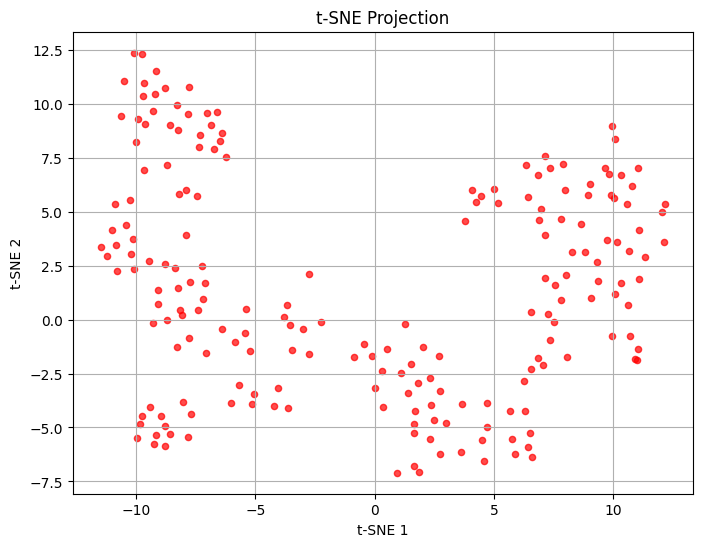

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1] ,s=20, alpha=0.7,color='red')
plt.title("t-SNE Projection")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

Create 2D t-SNE plots before clustering


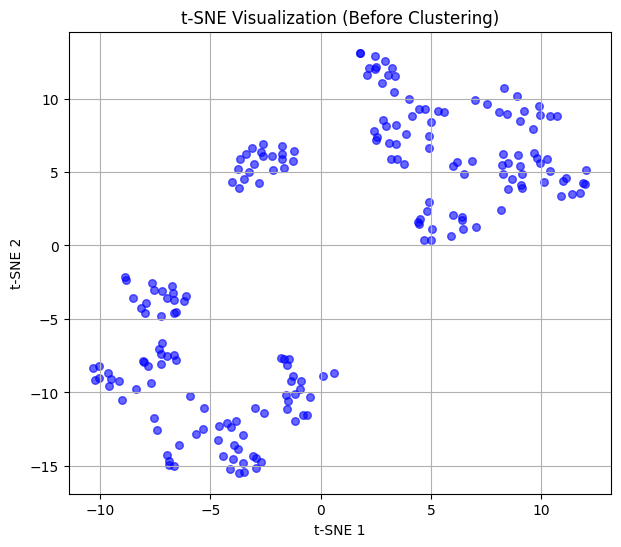

In [18]:
tsne_before = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne_before = tsne_before.fit_transform(X_scaled)

plt.figure(figsize=(7, 6))
plt.scatter(X_tsne_before[:, 0], X_tsne_before[:, 1], s=30, alpha=0.6, color='b')
plt.title("t-SNE Visualization (Before Clustering)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

Create 2D t-SNE plots after clustering


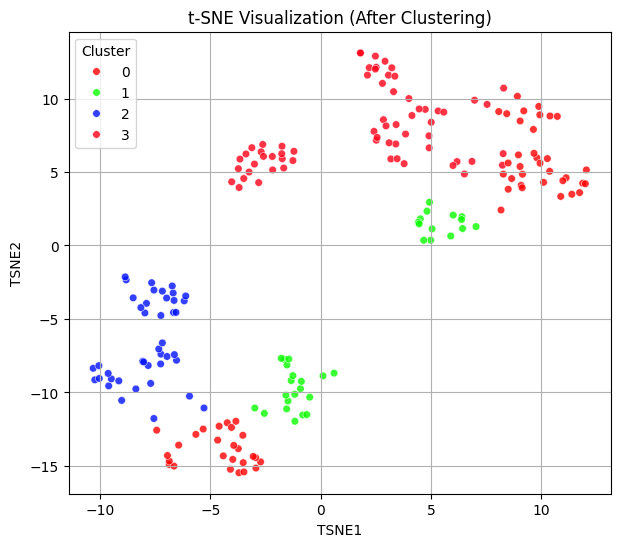

In [35]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)


tsne_after = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne_after = tsne_after.fit_transform(X_scaled)

tsne_df = pd.DataFrame(X_tsne_after, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = cluster_labels


plt.figure(figsize=(7, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='hsv', s=30, alpha=0.8)
plt.title("t-SNE Visualization (After Clustering)")
plt.grid(True)
plt.show()

#Clustering

KMeans

In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)


KMeans(n_clusters=2, random_state=42)

Use the Elbow method and Silhouette score to determine best k

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
sil_scores = []
Ks = range(2, 11)
for k in Ks:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
    # Compute silhouette on a sample (to save time) or on full data if feasible
    sil = silhouette_score(X_pca, kmeans.labels_, sample_size=10000, random_state=42)
    sil_scores.append(sil)
    print(f"k={k}, inertia={kmeans.inertia_:.2f}, silhouette={sil:.3f}")


k=2, inertia=272.16, silhouette=0.401
k=3, inertia=187.91, silhouette=0.389
k=4, inertia=125.49, silhouette=0.416
k=5, inertia=104.78, silhouette=0.388
k=6, inertia=86.82, silhouette=0.394
k=7, inertia=73.85, silhouette=0.381
k=8, inertia=66.41, silhouette=0.364
k=9, inertia=57.95, silhouette=0.366
k=10, inertia=51.68, silhouette=0.383


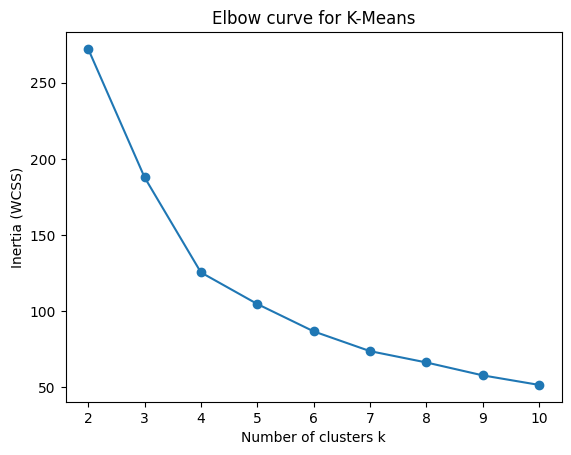

In [23]:
plt.figure()
plt.plot(Ks, inertias, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow curve for K-Means')
plt.show()
#The graph shows that the best value is when k = 4

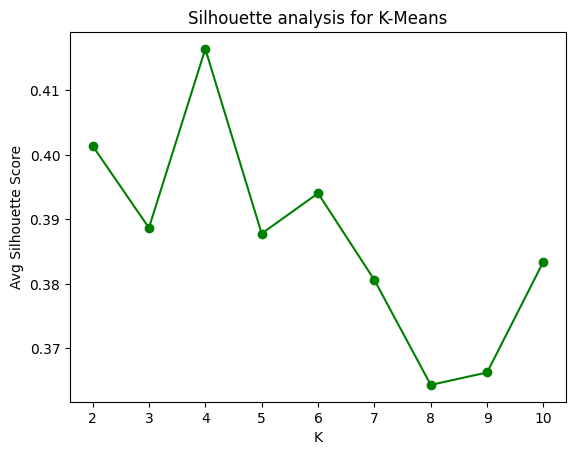

In [24]:
plt.figure()
plt.plot(Ks, sil_scores, marker='o', c='green')
plt.xlabel('K')
plt.ylabel('Avg Silhouette Score')
plt.title('Silhouette analysis for K-Means')
plt.xticks(Ks)
plt.show()


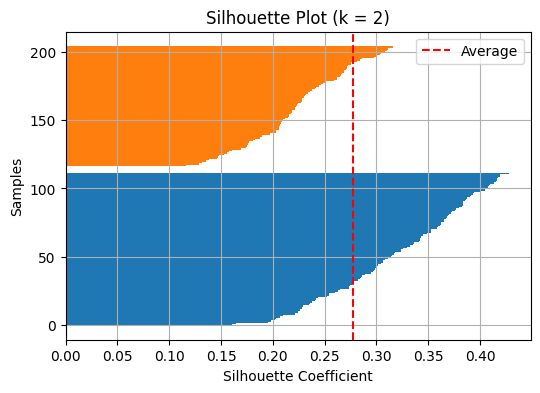

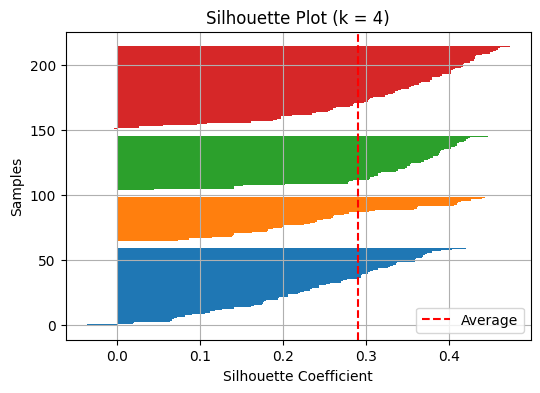

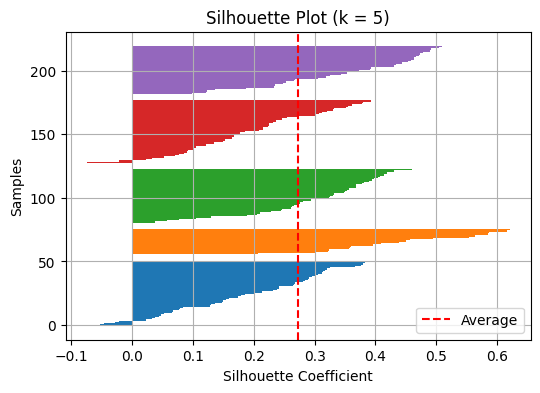

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def plot_silhouette(X, k):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    silhouette_vals = silhouette_samples(X, labels)
    avg_score = silhouette_score(X, labels)

    plt.figure(figsize=(6, 4))
    y = 0
    for i in range(k):
        cluster_vals = silhouette_vals[labels == i]
        cluster_vals.sort()
        n = len(cluster_vals)
        plt.barh(range(y, y + n), cluster_vals, height=1.0)
        y += n + 5

    plt.axvline(avg_score, color='red', linestyle='--', label='Average')
    plt.title(f'Silhouette Plot (k = {k})')
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Samples')
    plt.legend()
    plt.grid(True)
    plt.show()

for k in [2, 4, 5]:
    plot_silhouette(X_scaled, k)
